In [1]:
import torch

from fourier_scaffold import (
    FourierScaffold,
    FourierScaffoldDebug,
    HammardSharpening,
    ContractionSharpening,
    GaussianFourierSmoothing,
    GuassianFourierSmoothingMatrix,
    HammardShiftMatrix,
    calculate_padding,
)
import math
import matplotlib.pyplot as plt

device = "cuda"
shapes = torch.tensor([(5, 5), (7, 7)], device=device)
nruns=5
dim_sizes = [int(shapes[:, dim].prod().item()) for dim in range(shapes.shape[1])]


def zero():
    return torch.zeros(*dim_sizes, device=device)


def uniform():
    t = torch.ones_like(zero())
    return t / t.sum()


def degenerate():
    t = zero()
    t[tuple([0] * shapes.shape[1])] = 1
    return t


def gaussian(sigma=1):
    t = degenerate()
    kernel_size = 2 * max(10, 3 * math.ceil(sigma)) + 1
    x = torch.arange(kernel_size, device=device) - kernel_size // 2
    y = torch.arange(kernel_size, device=device) - kernel_size // 2
    x, y = torch.meshgrid(x, y)
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()

    x_padding = calculate_padding(kernel_size, kernel.shape[0], 1)
    y_padding = calculate_padding(kernel_size, kernel.shape[1], 1)

    padded = torch.nn.functional.pad(
        t.unsqueeze(0).unsqueeze(0),
        y_padding + x_padding,
        mode="circular",
    )

    convoluted = torch.nn.functional.conv2d(
        input=padded, weight=kernel.unsqueeze(0).unsqueeze(0)
    )

    return convoluted.squeeze(0).squeeze(0)


def bimodal():
    t = zero()
    index = [0] * shapes.shape[1]
    for i, size in enumerate(dim_sizes):
        index[i] = size // 2

    t[tuple([0] * shapes.shape[1])] = 0.5
    t[tuple(index)] = 0.5
    return t

/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash_functions.py:1: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.special


In [2]:
distributions = [
    ("degenerate", degenerate()),
    ("uniform", uniform()),
    ("gaussian 0.5", gaussian(0.5)),
    ("gaussian 1", gaussian(1)),
    ("gaussian 2", gaussian(2)),
    ("bimodal", bimodal()),
]

scaffold_debug = FourierScaffoldDebug(shapes, device=device)


def run_test(
    distribution: torch.Tensor,
    scaffold: FourierScaffold,
    scaffold_debug: FourierScaffoldDebug,
):
    scaffold.g = scaffold.encode_probability(distribution)
    scaffold_debug.ptensor = distribution

    # print(scaffold.g)
    # print(scaffold_debug.ptensor)

    estimated = scaffold.get_all_probabilities().flatten()
    true = scaffold_debug.ptensor.flatten()
    encoding_similarity = torch.cosine_similarity(true, estimated, dim=0)
    print("encoding similarity:", encoding_similarity)

    scaffold.sharpen()
    scaffold_debug.sharpen()

    # print(scaffold.g)
    # print(scaffold_debug.ptensor)

    estimated = scaffold.get_all_probabilities().flatten()
    true = scaffold_debug.ptensor.flatten()
    sharpening_similarity = torch.cosine_similarity(true, estimated, dim=0)
    print( "similarity after sharpning:", sharpening_similarity)
    return encoding_similarity, sharpening_similarity

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ezrahuang/Projects/rl-research/vectorhash/fourier_scaffold.py:411: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


In [3]:
# (Ds (3), methods (2))
Ds = [10, 31, 100, 310, 1000]

encoding_similarities = torch.zeros(len(distributions), len(Ds), 2, nruns)
shapened_similarities = torch.zeros(len(distributions), len(Ds), 2, nruns)


for i, [name, distribution] in enumerate(distributions):
    for j, D in enumerate(Ds):
        for run in range(nruns):
            print(
                f" ----------------------- running test: {name} ({i}/{len(distributions)}), D={D} ({j}/{len(Ds)}), run {run}/{nruns} --------------------"
            )
            scaffold_v = FourierScaffold(
                shapes,
                D=D**2,
                sharpening=HammardSharpening(2),
                smoothing=GaussianFourierSmoothing(
                    kernel_radii=[10, 10], kernel_sigmas=[1, 1]
                ),  # doesnt matter just so it runs
                device=device,
            )
            scaffold_m = FourierScaffold(
                shapes,
                D=D,
                sharpening=ContractionSharpening(2),
                shift=HammardShiftMatrix(),
                smoothing=GuassianFourierSmoothingMatrix(
                    kernel_radii=[10, 10], kernel_sigmas=[1, 1]
                ),  # doesnt matter just so it runs
                device=device,
                representation="matrix",
            )
            scaffold_debug = FourierScaffoldDebug(shapes, device=device)

            encoding_similarity_v, sharpened_similarity_v = run_test(
                distribution, scaffold_v, scaffold_debug
            )
            encoding_similarity_m, sharpened_similarity_m = run_test(
                distribution, scaffold_m, scaffold_debug
            )

            encoding_similarities[i, j, 0, run] = encoding_similarity_v
            encoding_similarities[i, j, 1, run] = encoding_similarity_m
            shapened_similarities[i, j, 0, run] = sharpened_similarity_v
            shapened_similarities[i, j, 1, run] = sharpened_similarity_m

 ----------------------- running test: degenerate (0/6), D=10 (0/5), run 0/5 --------------------


/home/ezrahuang/Projects/rl-research/vectorhash/fourier_scaffold.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  100
M       :  2
d       :  2
N_patts :  1225


/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash_functions.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(w).to(device).clip(1e-8)


module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  10
M       :  2
d       :  2
N_patts :  1225


/home/ezrahuang/Projects/rl-research/vectorhash/fourier_scaffold.py:372: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  ptensor[tuple(k)] = p


encoding similarity: tensor(0.3784, device='cuda:0')
similarity after sharpning: tensor(0.3784, device='cuda:0')
encoding similarity: tensor(0.2931, device='cuda:0')
similarity after sharpning: tensor(0.2931, device='cuda:0')
 ----------------------- running test: degenerate (0/6), D=10 (0/5), run 1/5 --------------------
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  100
M       :  2
d       :  2
N_patts :  1225
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  10
M       :  2
d       :  2
N_patts :  1225
encoding similarity: tensor(0.3853, device='cuda:0')
similarity after sharpning: tensor(0.3853, device='cuda:0')
encoding similarity: tensor(0.2901, device='cuda:0')
similarity after sharpning: tensor(-0.2901, device='cuda:0')
 ----------------------- running test: degenerate (0/6), D=10 (0/5), run 2/5 --------------------
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  100
M       :  2
d       :  2

In [7]:
import pickle

with open("encoding_similarities.pkl", "wb") as f:
    pickle.dump(encoding_similarities, f)

with open("sharpened_similarities.pkl", "wb") as f:
    pickle.dump(shapened_similarities, f)

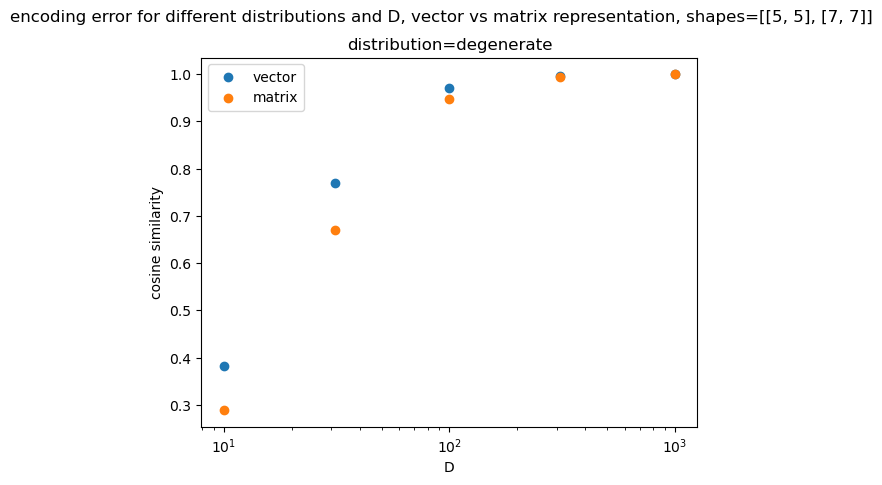

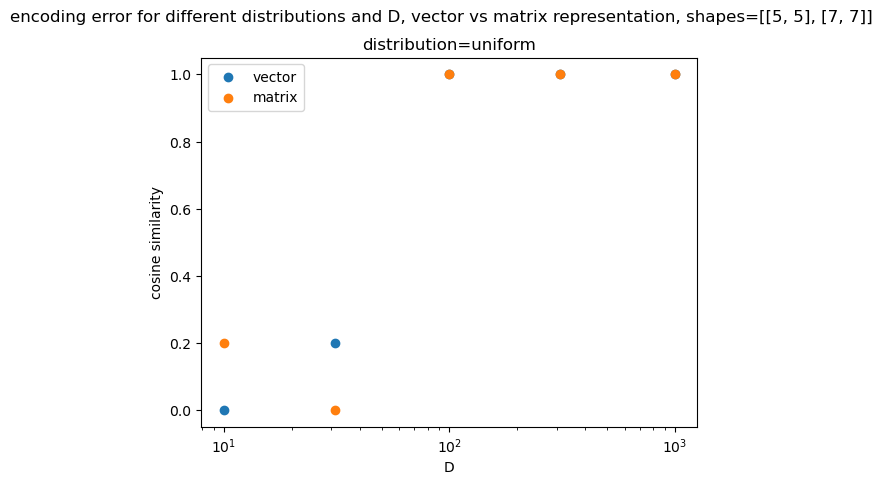

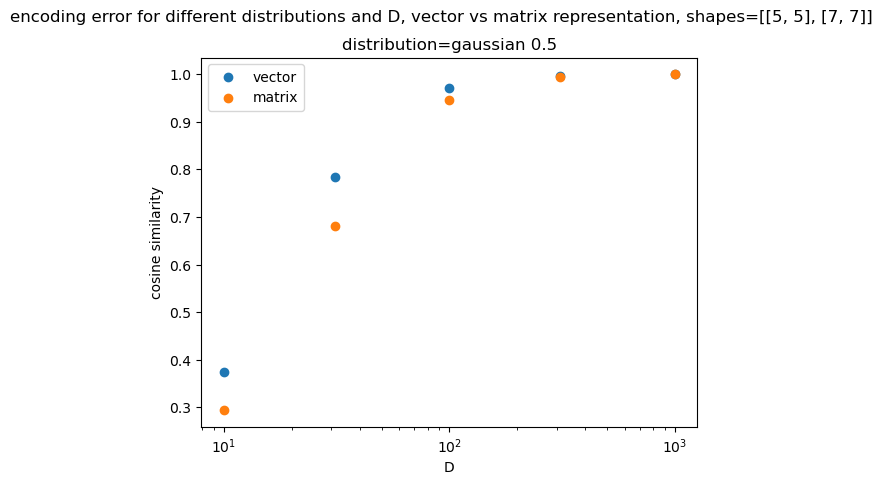

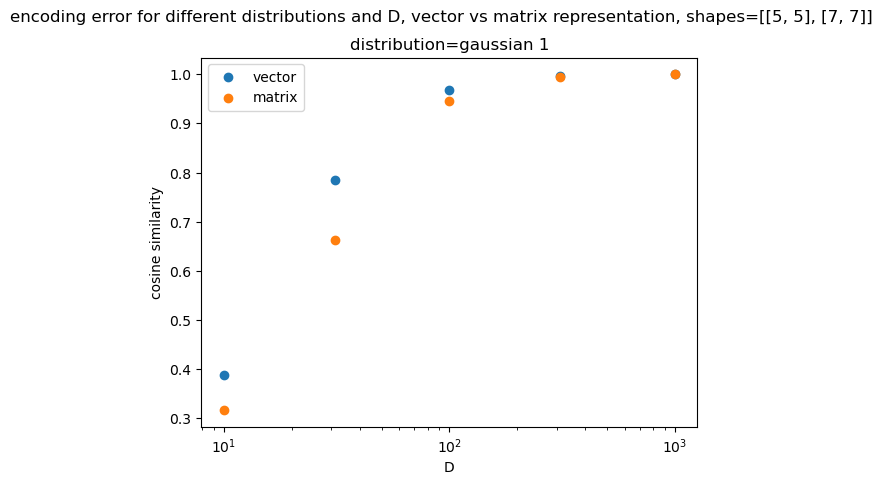

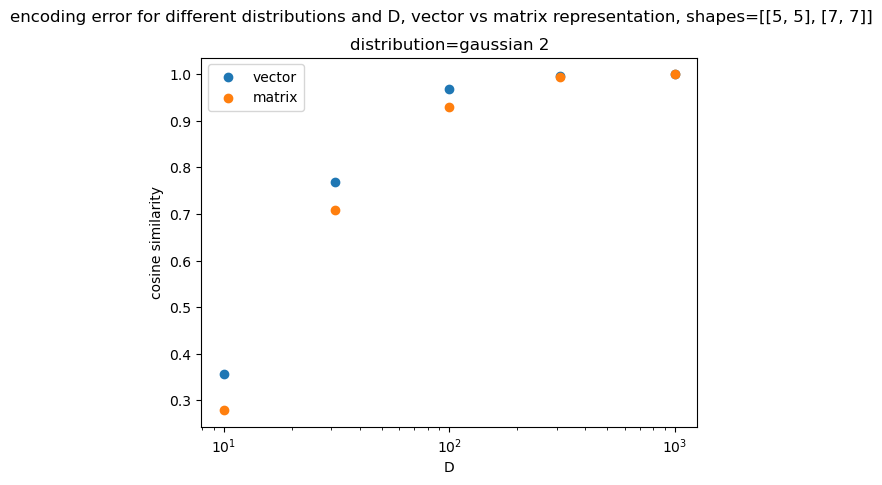

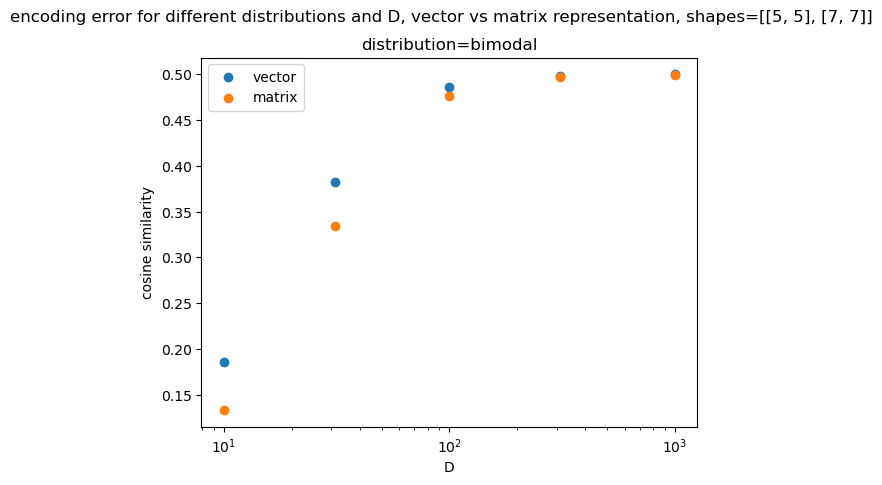

In [5]:
import matplotlib.pyplot as plt

for i, [name, distribution] in enumerate(distributions):
  fig, ax = plt.subplots()
  ax.scatter(Ds, encoding_similarities[i, :, 0].mean(dim=1), label="vector")
  ax.scatter(Ds, encoding_similarities[i, :, 1].mean(dim=1), label="matrix")
  ax.set_xscale('log')
  ax.legend()
  ax.set_ylabel('cosine similarity')
  ax.set_xlabel('D')
  ax.set_title(f'distribution={name}')
  fig.suptitle(f'encoding error for different distributions and D, vector vs matrix representation, shapes={shapes.cpu().tolist()}')

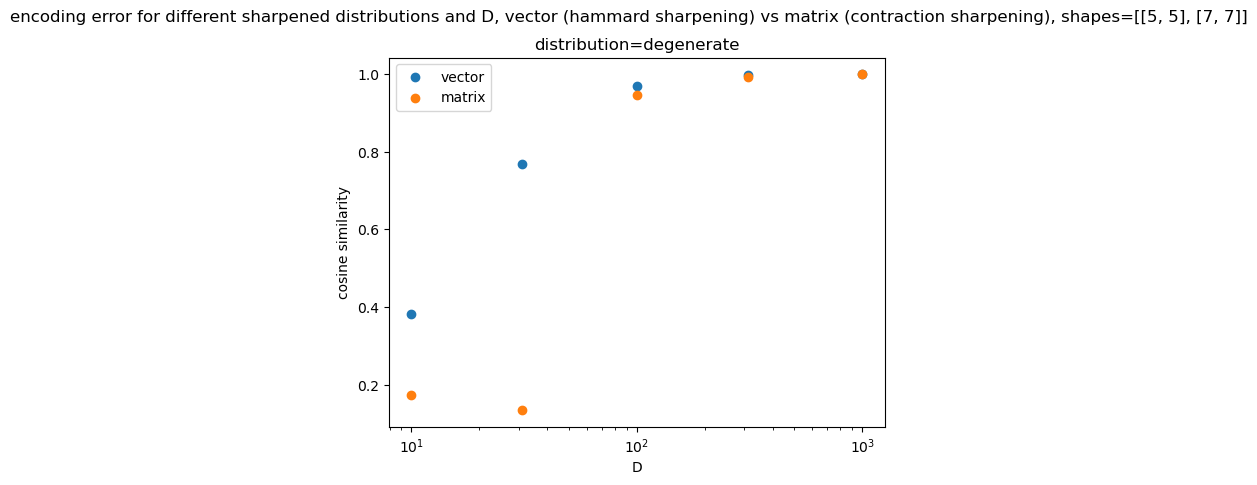

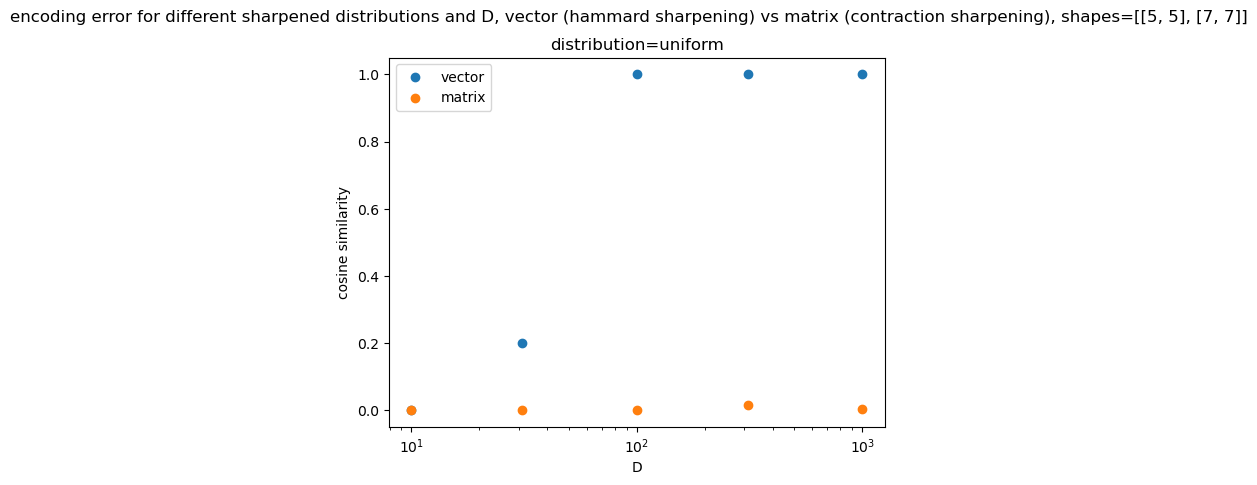

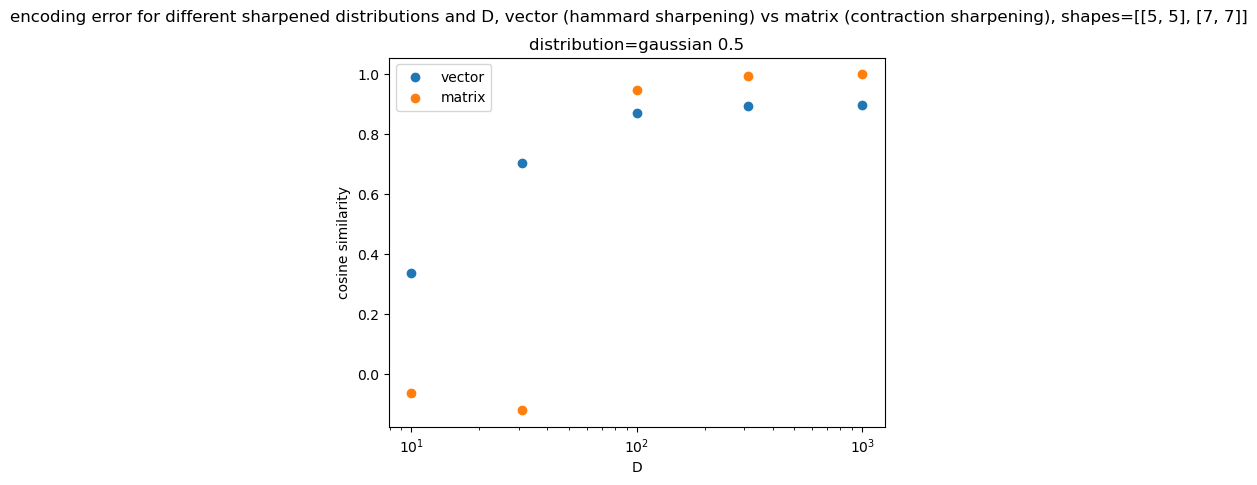

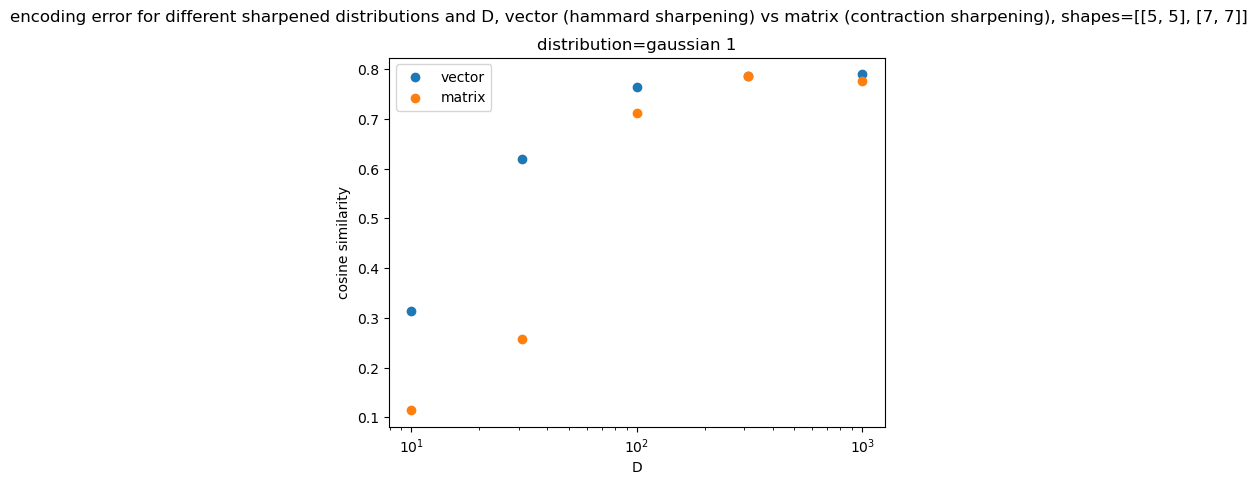

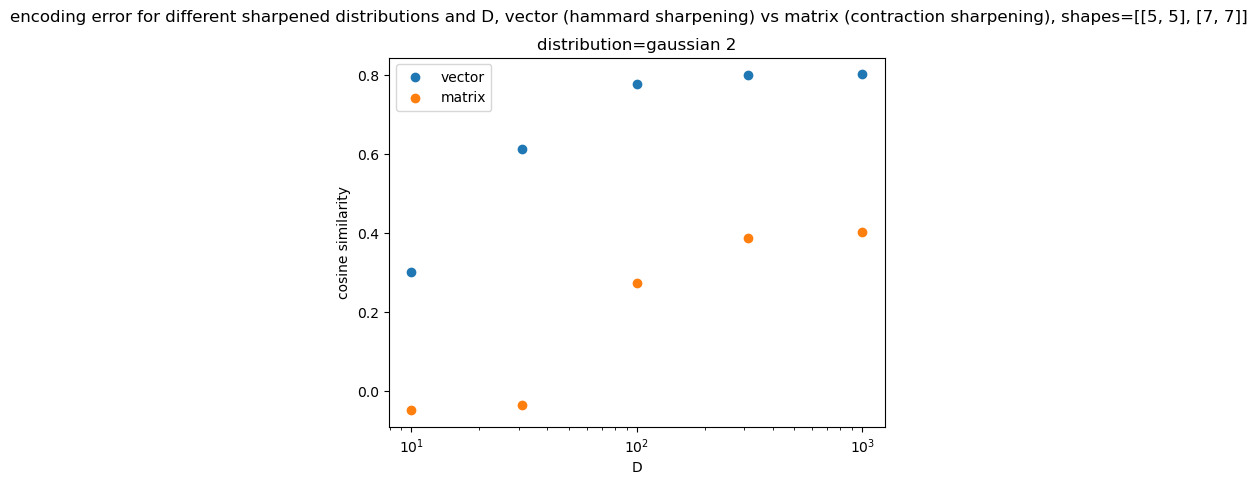

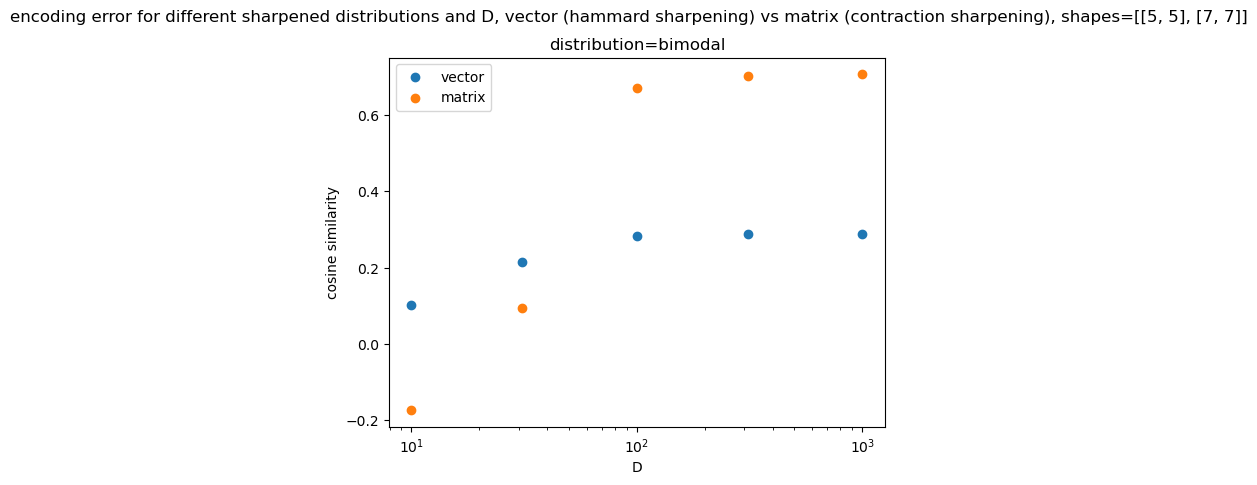

In [6]:
import matplotlib.pyplot as plt

# D vs. encoding similarity

# shapened_similarities = torch.zeros(len(distributions), len(Ds), 2)

for i, [name, distribution] in enumerate(distributions):
  fig, ax = plt.subplots()
  ax.scatter(Ds, shapened_similarities[i, :, 0].mean(dim=1), label="vector")
  ax.scatter(Ds, shapened_similarities[i, :, 1].mean(dim=1), label="matrix")
  ax.set_xscale('log')
  ax.legend()
  ax.set_ylabel('cosine similarity')
  ax.set_xlabel('D')
  ax.set_title(f'distribution={name}')
  fig.suptitle(f'encoding error for different sharpened distributions and D, vector (hammard sharpening) vs matrix (contraction sharpening), shapes={shapes.cpu().tolist()}')